<a href="https://colab.research.google.com/github/EdibHamzaArslan/OneShotLearning-with-Face2Vec/blob/main/OneShotLearning_Face2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from models.slim_cnn import SlimCNN
from models.config import Config

In [ ]:
# filters = Config()
# model = SlimCNN(filters.layers, 
#                 filters.conv_filter_size, 
#                 filters.conv_filter, 
#                 filters.conv_stride, 
#                 filters.max_pool_filter, 
#                 filters.max_pool_stride)

# model = model.my_compile(model, dynamic_mode=False)
# model.summary()

Model: "slim_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 89, 109, 96)       14208     
_________________________________________________________________
batch_normalization (BatchNo (None, 89, 109, 96)       384       
_________________________________________________________________
slim_module (SlimModule)     (None, 44, 54, 48)        30896     
_________________________________________________________________
slim_module_1 (SlimModule)   (None, 21, 26, 96)        72544     
_________________________________________________________________
slim_module_2 (SlimModule)   (None, 10, 12, 144)       166416    
_________________________________________________________________
slim_module_3 (SlimModule)   (None, 4, 5, 192)         298688    
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0  

In [ ]:
# !gdown --id 1Of_EVz-yHV7QVWQGihYfvtny9Ne8qXVz ## CASIA WebFace
# !unzip  'CASIA-WebFace.zip'

In [ ]:
#### Siamese Network Data Generator 
import pandas as pd
from data_generator import DataGenerator

df = pd.read_csv('CASIA_WebFace_pretrained.csv')

In [ ]:
# The total length of df is 79290. %80 is training, %10 val, %10 val 
train_df = df[:63432]
val_df = df[63432:71361]
test_df = df[71361: 79290]

In [ ]:


train_x1 = train_df['image1'].to_numpy()
train_x2 = train_df['image2'].to_numpy()
train_y = list(train_df['similarity'].to_numpy())

val_x1 = val_df['image1'].to_numpy()
val_x2 = val_df['image2'].to_numpy()
val_y = list(val_df['similarity'].to_numpy())

test_x1 = test_df['image1'].to_numpy()
test_x2 = test_df['image2'].to_numpy()
test_y = list(test_df['similarity'].to_numpy())

train_gen = DataGenerator(train_x1, train_x2, train_y)
val_gen = DataGenerator(val_x1, val_x2, val_y)
test_gen = DataGenerator(test_x1, test_x2, test_y)

In [ ]:
import tensorflow as tf

#### Siamese Network Setup
filters = Config()

input1 = tf.keras.layers.Input(shape=filters.input_size)
input2 = tf.keras.layers.Input(shape=filters.input_size)

base_model = SlimCNN(filters.layers, 
                filters.conv_filter_size, 
                filters.conv_filter, 
                filters.conv_stride, 
                filters.max_pool_filter, 
                filters.max_pool_stride)

saved_weights_path = '/content/drive/MyDrive/SlimCnn_savedWeights/Checkpoints/slim_cnn_model.013.0.22.h5'

output1 = base_model(input1)
output2 = base_model(input2)

base_model.load_weights(saved_weights_path)



In [ ]:
from tensorflow.keras import backend as K


def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)



@tf.function
def euclidean_distance(vectors):
  (vector1, vector2) = vectors
  # compute the sum of squared distances between the vectors
  sumSquared = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
  # return the euclidean distance between the vectors
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

@tf.function
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


@tf.function
def contrastive_loss(y, preds, margin=1):
  y = tf.cast(y, preds.dtype)
  squaredPreds = K.square(preds)
  squaredMargin = K.square(K.maximum(margin - preds, 0))
  loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
  return loss

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
 
@tf.function
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


distance = tf.keras.layers.Lambda(euclidean_distance, 
                                  output_shape=eucl_dist_output_shape)([output1, output2])
model = tf.keras.Model(inputs=[input1, input2], outputs=[distance])
model.summary()
model.compile(optimizer='adam', loss=contrastive_loss, metrics=[accuracy])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 178, 218, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 178, 218, 3) 0                                            
__________________________________________________________________________________________________
slim_cnn (SlimCNN)              (None, 40)           590856      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           slim_cnn[0][0]               

In [ ]:

# model.load_weights('/content/weights.57-0.06.h5')
# model.load_weights('/content/drive/MyDrive/Face2VecOneShot/weights.22-0.94.h5')

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_1 True
input_2 True
slim_cnn True
lambda True


In [ ]:
# 8h 12m
# import os
# EPOCHS = 100
# save_path = '/content/drive/MyDrive/Face2VecOneShot'
# if not os.path.exists(save_path):
#   os.mkdir(save_path)
# checkpoint_filepath = os.path.join(save_path, 'weights.{epoch:02d}-{val_loss:.2f}.h5')
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True,
#     verbose=1)
# history = model.fit(train_gen,
#                     validation_data=val_gen,
#                     epochs=EPOCHS,
#                     callbacks=[model_checkpoint_callback])

Epoch 1/100
991/991 [==============================] - 465s 459ms/step - loss: 0.2721 - accuracy: 0.5711 - val_loss: 0.2268 - val_accuracy: 0.6378

Epoch 00001: val_accuracy improved from -inf to 0.63783, saving model to Checkpoints/weights.01-0.23.h5
Epoch 2/100
991/991 [==============================] - 456s 460ms/step - loss: 0.2244 - accuracy: 0.6358 - val_loss: 0.2123 - val_accuracy: 0.6700

Epoch 00002: val_accuracy improved from 0.63783 to 0.66997, saving model to Checkpoints/weights.02-0.21.h5
Epoch 3/100
991/991 [==============================] - 456s 460ms/step - loss: 0.2046 - accuracy: 0.6766 - val_loss: 0.1960 - val_accuracy: 0.6892

Epoch 00003: val_accuracy improved from 0.66997 to 0.68915, saving model to Checkpoints/weights.03-0.20.h5
Epoch 4/100
991/991 [==============================] - 456s 460ms/step - loss: 0.1860 - accuracy: 0.7100 - val_loss: 0.2027 - val_accuracy: 0.6698

Epoch 00004: val_accuracy did not improve from 0.68915
Epoch 5/100
991/991 [==============

In [ ]:
# 2h 
# import os
# EPOCHS = 100
# save_path = '/content/drive/MyDrive/Face2VecOneShot'
# if not os.path.exists(save_path):
#   os.mkdir(save_path)
# checkpoint_filepath = os.path.join(save_path, 'weights.{epoch:02d}-{val_accuracy:.2f}.h5')
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True,
#     verbose=1)
# history = model.fit(train_gen,
#                     validation_data=val_gen,
#                     epochs=EPOCHS,
#                     callbacks=[model_checkpoint_callback])

Epoch 1/100
991/991 [==============================] - 465s 459ms/step - loss: 0.0125 - accuracy: 0.9844 - val_loss: 0.0646 - val_accuracy: 0.9343

Epoch 00001: val_accuracy improved from -inf to 0.93432, saving model to /content/drive/MyDrive/Face2VecOneShot/weights.01-0.93.h5
Epoch 2/100
991/991 [==============================] - 456s 460ms/step - loss: 0.0116 - accuracy: 0.9855 - val_loss: 0.0632 - val_accuracy: 0.9345

Epoch 00002: val_accuracy improved from 0.93432 to 0.93445, saving model to /content/drive/MyDrive/Face2VecOneShot/weights.02-0.93.h5
Epoch 3/100
991/991 [==============================] - 457s 461ms/step - loss: 0.0111 - accuracy: 0.9866 - val_loss: 0.0761 - val_accuracy: 0.9168

Epoch 00003: val_accuracy did not improve from 0.93445
Epoch 4/100
991/991 [==============================] - 451s 455ms/step - loss: 0.0105 - accuracy: 0.9869 - val_loss: 0.0669 - val_accuracy: 0.9324

Epoch 00004: val_accuracy did not improve from 0.93445
Epoch 5/100
991/991 [============

In [ ]:
# 3h 40 min
import os
EPOCHS = 100
save_path = '/content/drive/MyDrive/Face2VecOneShot/Third_Training'
if not os.path.exists(save_path):
  os.mkdir(save_path)
checkpoint_filepath = os.path.join(save_path, 'weights.{epoch:02d}-{val_accuracy:.2f}.h5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=EPOCHS,
                    callbacks=[model_checkpoint_callback])

Epoch 1/100
991/991 [==============================] - 335s 330ms/step - loss: 0.0089 - accuracy: 0.9892 - val_loss: 0.0636 - val_accuracy: 0.9381

Epoch 00001: val_accuracy improved from -inf to 0.93814, saving model to /content/drive/MyDrive/Face2VecOneShot/Third_Training/weights.01-0.94.h5
Epoch 2/100
991/991 [==============================] - 307s 310ms/step - loss: 0.0069 - accuracy: 0.9920 - val_loss: 0.0586 - val_accuracy: 0.9444

Epoch 00002: val_accuracy improved from 0.93814 to 0.94436, saving model to /content/drive/MyDrive/Face2VecOneShot/Third_Training/weights.02-0.94.h5
Epoch 3/100
991/991 [==============================] - 307s 310ms/step - loss: 0.0077 - accuracy: 0.9908 - val_loss: 0.0774 - val_accuracy: 0.9234

Epoch 00003: val_accuracy did not improve from 0.94436
Epoch 4/100
991/991 [==============================] - 307s 309ms/step - loss: 0.0085 - accuracy: 0.9896 - val_loss: 0.0622 - val_accuracy: 0.9403

Epoch 00004: val_accuracy did not improve from 0.94436
Epo

KeyboardInterrupt: ignored

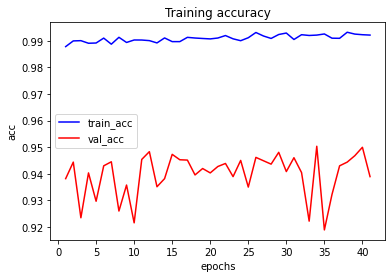

In [ ]:
import os
import matplotlib.pyplot as plt


train_acc, train_loss, val_acc, val_loss = model.history.history['accuracy'], model.history.history['loss'], model.history.history['val_accuracy'], model.history.history['val_loss']
model_result_path = 'Plots/'
epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.title("Training accuracy")
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend() # plt.legend(loc='lower right')
if not os.path.exists(model_result_path):
  os.mkdir(model_result_path)
plt.savefig(os.path.join(model_result_path, 'Acc.png'))
plt.show()

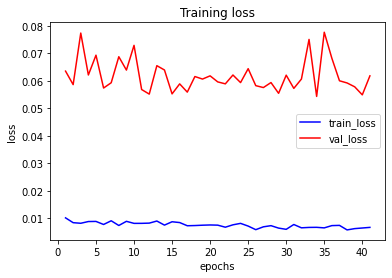

In [ ]:
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'b', label='train_loss')
plt.plot(epochs, val_loss, 'r', label='val_loss')
plt.title("Training loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend() # plt.legend(loc='lower right')
if not os.path.exists(model_result_path):
  os.mkdir(model_result_path)
plt.savefig(os.path.join(model_result_path, 'Loss.png'))
plt.show()

In [ ]:
best_weights_path = '/content/drive/MyDrive/Face2VecOneShot/Third_Training/weights.34-0.95.h5'
model.load_weights(best_weights_path)

In [ ]:
score = model.evaluate(test_gen)

123/123 [==============================] - 27s 222ms/step - loss: 0.0573 - accuracy: 0.9474


In [ ]:
score

[0.05725165829062462, 0.9474085569381714]

## Prediction Part

In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
for layer in model.layers:
  print(layer.name ,layer.trainable)

input_1 False
input_2 False
slim_cnn False
lambda False


In [ ]:
model.trainable = False

In [ ]:
def img2array(path):
  img = tf.keras.preprocessing.image.load_img(path, target_size=(178,218,3))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = img.astype("float32") / 255
  return np.expand_dims(img, axis=0)

In [ ]:
import numpy as np

input = ''
slimcnn = ''
distance_measure = ''

for layer in model.layers:
  if layer.name == 'input_1':
    input = layer
  elif layer.name == 'slim_cnn':
    slimcnn = layer
  elif layer.name == 'lambda':
    distance_measure = layer
  
img1 = img2array('/content/drive/MyDrive/Face2VecOneShot/test_imgs/face-beauty-skin-face2-proc.jpg')
img2 = img2array('/content/drive/MyDrive/Face2VecOneShot/test_imgs/best-face-oil.png')

encoder_model = tf.keras.Sequential()
encoder_model.add(input)
encoder_model.add(slimcnn)

vector1 = encoder_model(img1)
vector2 = encoder_model(img2)
distance = distance_measure([vector1, vector2])

In [ ]:
img1 vector1 
img2 vector2 
img3 vector3 
img4 vector4 




In [ ]:
vector1

<tf.Tensor: shape=(1, 40), dtype=float32, numpy=
array([[9.9999666e-01, 1.6785508e-06, 4.4349913e-06, 2.1606074e-06,
        2.4292663e-06, 4.3182939e-07, 8.1940722e-01, 9.9999702e-01,
        3.7820739e-06, 1.1932702e-06, 9.9316162e-07, 1.2450316e-06,
        2.5964330e-06, 7.6832146e-07, 1.8610277e-06, 1.9938666e-06,
        1.1561137e-06, 3.6051426e-07, 1.0051275e-06, 9.9999928e-01,
        7.2836161e-07, 2.6539531e-06, 8.2793787e-07, 8.8505542e-01,
        9.9999869e-01, 1.9539073e-06, 2.2906581e-06, 2.5484339e-06,
        7.2942447e-07, 7.2501018e-07, 5.3238955e-07, 1.1820639e-06,
        3.8369681e-06, 1.1300565e-06, 5.1062915e-07, 3.0268538e-06,
        2.4472874e-06, 1.5333030e-06, 4.7320309e-06, 9.9999779e-01]],
      dtype=float32)>

In [ ]:
vector1.numpy()[0]

array([9.9999666e-01, 1.6785508e-06, 4.4349913e-06, 2.1606074e-06,
       2.4292663e-06, 4.3182939e-07, 8.1940722e-01, 9.9999702e-01,
       3.7820739e-06, 1.1932702e-06, 9.9316162e-07, 1.2450316e-06,
       2.5964330e-06, 7.6832146e-07, 1.8610277e-06, 1.9938666e-06,
       1.1561137e-06, 3.6051426e-07, 1.0051275e-06, 9.9999928e-01,
       7.2836161e-07, 2.6539531e-06, 8.2793787e-07, 8.8505542e-01,
       9.9999869e-01, 1.9539073e-06, 2.2906581e-06, 2.5484339e-06,
       7.2942447e-07, 7.2501018e-07, 5.3238955e-07, 1.1820639e-06,
       3.8369681e-06, 1.1300565e-06, 5.1062915e-07, 3.0268538e-06,
       2.4472874e-06, 1.5333030e-06, 4.7320309e-06, 9.9999779e-01],
      dtype=float32)

In [ ]:
meaned_vectors = np.mean([vector1.numpy()[0],vector2.numpy()[0]], axis=0)
distance = distance_measure([meaned_vectors, vector3])

In [ ]:
distance

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.0859543]], dtype=float32)>

In [ ]:
distance

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.802948]], dtype=float32)>

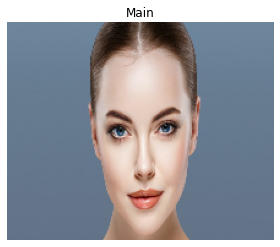

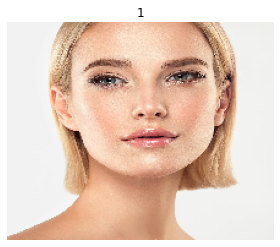

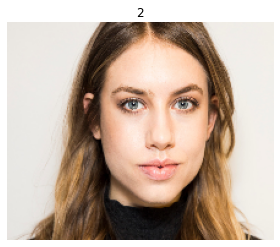

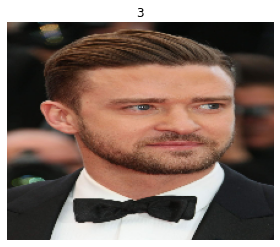

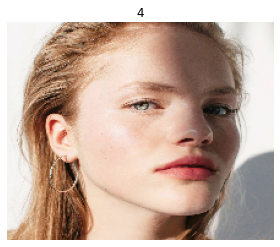

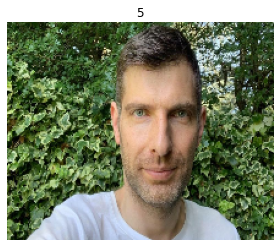

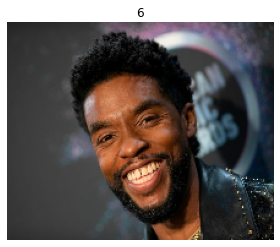

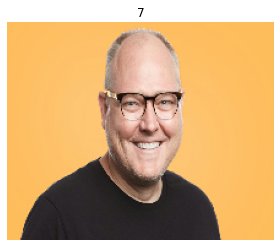

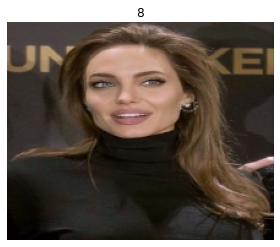

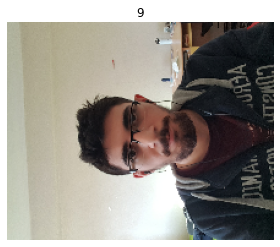

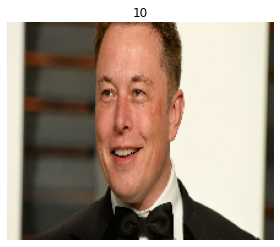

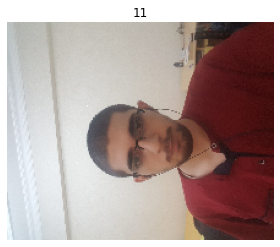

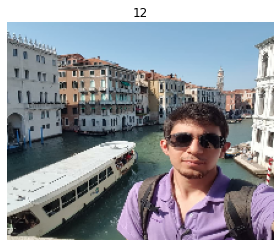

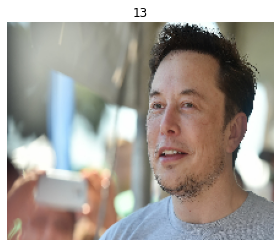

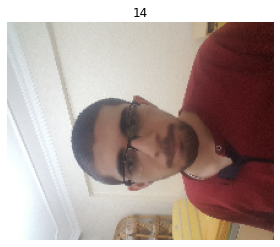

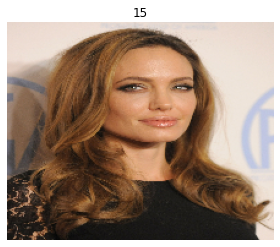

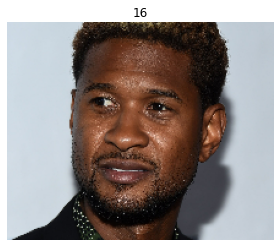

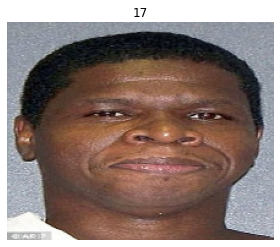

In [ ]:
import tensorflow as tf 
import numpy as np 
import os
import matplotlib.pyplot as plt



def img2array(path):
  img = tf.keras.preprocessing.image.load_img(path, target_size=(178,218,3))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = img.astype("float32") / 255
  return np.expand_dims(img, axis=0)

def predict(img_path, file_list_path, result={}):
  source = img2array(img_path)
  file_list = os.listdir(file_list_path)
  for img in file_list:
    target_path = os.path.join(file_list_path, img)
    if target_path == img_path:
      continue
    target = img2array(target_path)
    pred = model.predict((source, target))[0][0]
    result[pred] = target_path
  return result

def parse_image(filename):
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [178, 218])
  return image

def show(image, label):
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')
  plt.show()

def print_results(img, result):
  keys = list(result.keys())
  indexes = np.argsort(keys)
  show(parse_image(img), 'Main')
  for i, index in enumerate(indexes):
    show(parse_image(result[keys[index]]), i+1)
    # print(result[keys[index]])

img = '/content/drive/MyDrive/Face2VecOneShot/test_imgs/1493458748-beauty-face-517.jpg'
file_list = '/content/drive/MyDrive/Face2VecOneShot/test_imgs'
result = predict(img, file_list)
print_results(img, result)

In [ ]:
result

{0.21391337: '/content/drive/MyDrive/Face2VecOneShot/test_imgs/face-beauty-skin-face2-proc.jpg',
 0.97526693: '/content/drive/MyDrive/Face2VecOneShot/test_imgs/best-face-oil.png',
 0.999714: '/content/drive/MyDrive/Face2VecOneShot/test_imgs/Justin-Timberlake-Round-Face-High-Volume-Hairstyle-e1537159113366.jpg',
 0.9999796: '/content/drive/MyDrive/Face2VecOneShot/test_imgs/face-wash-2-1561136582.jpg',
 1.0004579: '/content/drive/MyDrive/Face2VecOneShot/test_imgs/960x0.jpg',
 1.0039222: '/content/drive/MyDrive/Face2VecOneShot/test_imgs/skynews-chadwick-boseman-awards_5080480.jpg',
 1.015538: '/content/drive/MyDrive/Face2VecOneShot/test_imgs/round-face_header.jpg',
 1.2915076: '/content/drive/MyDrive/Face2VecOneShot/test_imgs/ag2.jpg',
 1.2917956: '/content/drive/MyDrive/Face2VecOneShot/test_imgs/20210328_171232.jpg',
 1.3822427: '/content/drive/MyDrive/Face2VecOneShot/test_imgs/elon_3.jpg',
 1.4030367: '/content/drive/MyDrive/Face2VecOneShot/test_imgs/20201022_191009.jpg',
 1.4114802: '/

In [ ]:
%%shell
cd test_imgs
rm -r .ipynb_checkpoints/
rm -f .config/

In [ ]:
# !cp -r test_imgs /content/drive/MyDrive/Face2VecOneShot/